In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd

# then import my own modules
from FusedEmbedding import save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [2]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class FusedEmbedding(nn.Module):

    def __init__(self, radius, T, input_feature_dim, input_bond_dim,\
            fingerprint_dim, embedding_dim, output_units_num, p_dropout=0.0):
        super(FusedEmbedding, self).__init__()
        self.dropout = nn.Dropout(p=p_dropout)
        self.atom_fc = nn.Linear(input_feature_dim, fingerprint_dim)        
        self.neighbor_fc = nn.Linear(input_feature_dim+input_bond_dim, fingerprint_dim)
        self.atom_GRU = nn.ModuleList([nn.GRUCell(fingerprint_dim, fingerprint_dim) for r in range(radius)])

        self.fused_GRU = nn.GRUCell(embedding_dim, fingerprint_dim)
        self.output = nn.Linear(fingerprint_dim, output_units_num) 
        self.radius = radius
        self.T = T
        self.embedding_dim = embedding_dim

    def forward(self, atom_list, bond_list, atom_degree_list, bond_degree_list, atom_mask, seq_embeddings):
        atom_mask = atom_mask.unsqueeze(2)
        batch_size,mol_length,num_atom_feat = atom_list.size()
        atom_feature = F.relu(self.atom_fc(atom_list)) * atom_mask

        bond_neighbor = [bond_list[i][bond_degree_list[i]] for i in range(batch_size)]
        bond_neighbor = torch.stack(bond_neighbor, dim=0)
        atom_neighbor = [atom_list[i][atom_degree_list[i]] for i in range(batch_size)]
        atom_neighbor = torch.stack(atom_neighbor, dim=0)
        # then catenate them
        neighbor_feature = torch.cat([atom_neighbor, bond_neighbor],dim=-1)
#         print(neighbor_feature.shape, neighbor_feature[0][0])
        max_features = torch.max(neighbor_feature,dim=-2)[0]
        max_features = F.relu(self.neighbor_fc(max_features))
#         print(max_features.shape, max_features[0])
        batch_size, mol_length, fingerprint_dim = atom_feature.shape
        atom_feature_reshape = atom_feature.view(batch_size*mol_length, fingerprint_dim)
        max_features_reshape = max_features.view(batch_size*mol_length, fingerprint_dim)
        atom_feature_GRU = self.atom_GRU[0](max_features_reshape, atom_feature_reshape)
        atom_feature = atom_feature_GRU.view(batch_size, mol_length, fingerprint_dim) * atom_mask        

        for d in range(self.radius-1):
            neighbor_feature = [atom_feature[i][atom_degree_list[i]] for i in range(batch_size)]
            # neighbor_feature is a list of 3D tensor, so we need to stack them into a 4D tensor first
            neighbor_feature = torch.stack(neighbor_feature, dim=0)
            # then max-pooling 
            max_features = torch.max(neighbor_feature,dim=-2)[0]

            atom_feature_reshape = atom_feature.view(batch_size*mol_length, fingerprint_dim)
            max_features_reshape = max_features.view(batch_size*mol_length, fingerprint_dim)
            atom_feature_GRU = self.atom_GRU[d+1](max_features_reshape, atom_feature_reshape)
            atom_feature = atom_feature_GRU.view(batch_size, mol_length, fingerprint_dim) * atom_mask
        mol_feature = torch.sum(atom_feature,-2)            
        fused_feature = mol_feature
        for t in range(self.T):
            fused_feature = self.fused_GRU(seq_embeddings, fused_feature)
        fused_prediction = self.output(self.dropout(F.relu(fused_feature)))
        return fused_prediction

In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score

1.0    155404
0.0     89173
2.0     34524
Name: class, dtype: int64
kinase count: 392
similes count: 2140
number of all smiles:  2140
number of successfully processed smiles:  2140


/home/pytorch/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


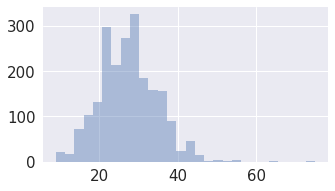

In [4]:
task_name = 'Multi-Targeting'
tasks = ['activity']
kinase_seq_embedding = pd.read_csv('../data/kinase_seq_embedding.csv')
smiles_kinase_class = pd.read_csv('../data/smiles_kinase_class_2.csv')
print(smiles_kinase_class['class'].value_counts())
print('kinase count:',len(smiles_kinase_class['kinase'].value_counts()))
print('similes count:',len(smiles_kinase_class['smiles'].value_counts()))

seq_embeddings_dict = {}
for kinase in list(set(smiles_kinase_class['kinase'].values)):
    seq_embeddings_dict[kinase] = [float(x) for x in kinase_seq_embedding.loc[kinase_seq_embedding['kinase']==kinase].embedding.values[0]\
                                 .replace("[", "").replace("]", "").replace(" ", "").split(',')]

smiles_kinase_class['embedding'] = [seq_embeddings_dict[kinase] for kinase in smiles_kinase_class['kinase'].values]

smilesList = list(set(smiles_kinase_class.smiles.values))
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()

In [5]:
random_seed = 28
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 500
epochs = 100
p_dropout = 0.18
fingerprint_dim = 180

radius = 5
T = 3
weight_decay = 4.5 # also known as l2_regularization_lambda
learning_rate = 2.8
embedding_dim = 100
output_units_num = 3 # for classification model

In [6]:
test_df = smiles_kinase_class.sample(frac=1/10, random_state=random_seed) # test set
training_data = smiles_kinase_class.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [7]:
inactive_count = training_data['class'].value_counts()[0]
weak_count = training_data['class'].value_counts()[1]
potent_count = training_data['class'].value_counts()[2]
all_count = len(training_data)
# loss weight is inverse proportional to number of samples in each class
loss_weight = [all_count/inactive_count, all_count/weak_count, all_count/potent_count]
print(loss_weight)

[3.136750749250749, 1.7930559422089927, 8.097711154094133]


In [8]:
feature_dicts = get_smiles_dicts(smilesList)
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = nn.CrossEntropyLoss() # torch.Tensor(loss_weight)
model = FusedEmbedding(radius, T, num_atom_features, num_bond_features,\
            fingerprint_dim, embedding_dim, output_units_num, p_dropout)
model.cuda()

optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)


In [9]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
# for p in model.parameters():
#     if p.dim() > 1:
#         nn.init.xavier_uniform_(p)
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

1146423
atom_fc.weight torch.Size([180, 39])
atom_fc.bias torch.Size([180])
neighbor_fc.weight torch.Size([180, 49])
neighbor_fc.bias torch.Size([180])
atom_GRU.0.weight_ih torch.Size([540, 180])
atom_GRU.0.weight_hh torch.Size([540, 180])
atom_GRU.0.bias_ih torch.Size([540])
atom_GRU.0.bias_hh torch.Size([540])
atom_GRU.1.weight_ih torch.Size([540, 180])
atom_GRU.1.weight_hh torch.Size([540, 180])
atom_GRU.1.bias_ih torch.Size([540])
atom_GRU.1.bias_hh torch.Size([540])
atom_GRU.2.weight_ih torch.Size([540, 180])
atom_GRU.2.weight_hh torch.Size([540, 180])
atom_GRU.2.bias_ih torch.Size([540])
atom_GRU.2.bias_hh torch.Size([540])
atom_GRU.3.weight_ih torch.Size([540, 180])
atom_GRU.3.weight_hh torch.Size([540, 180])
atom_GRU.3.bias_ih torch.Size([540])
atom_GRU.3.bias_hh torch.Size([540])
atom_GRU.4.weight_ih torch.Size([540, 180])
atom_GRU.4.weight_hh torch.Size([540, 180])
atom_GRU.4.bias_ih torch.Size([540])
atom_GRU.4.bias_hh torch.Size([540])
fused_GRU.weight_ih torch.Size([540, 1

In [10]:
def train(model, dataset, optimizer, loss_function, epoch):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.smiles.values
        y_val = batch_df['class'].values
        seq_embeddings = list(batch_df.embedding.values)
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),\
                                                 torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),torch.Tensor(seq_embeddings))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
#         print(mol_prediction)
        model.zero_grad()
        # Compute your loss function. (Again, Torch wants the target wrapped in a variable)
        loss = loss_function(mol_prediction, torch.cuda.LongTensor(y_val))
        # Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
        
def eval(model, dataset):
    model.eval()
    y_val_list = []
    y_pred_list = []
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.smiles.values
        y_val = batch_df['class'].values
        seq_embeddings = list(batch_df.embedding.values)
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),\
                                                 torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),torch.Tensor(seq_embeddings))

        y_pred = torch.argmax(mol_prediction, dim=-1).data.squeeze().cpu().numpy()
        
        losses = F.cross_entropy(mol_prediction, torch.cuda.LongTensor(y_val), reduction='none').data.squeeze().cpu().numpy()
        y_val_list.extend(y_val)
        y_pred_list.extend(y_pred)
        losses_list.extend(losses)
        
    eval_losses = np.array(losses_list).mean()
    eval_accuracy= accuracy_score(y_val_list, y_pred_list)
    return eval_losses, eval_accuracy

In [11]:
log_file = 'result_log_5r_3T.csv'
with open(log_file,'a') as f:
    f.write(','.join(['epoch', 'train_losses','train_accuracy','valid_losses','valid_accuracy'])+'\n')

In [12]:
for epoch in range(80):
    train_losses, train_accuracy = eval(model, train_df)
    valid_losses, valid_accuracy = eval(model, valid_df)
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'saved_models/model_5r_3T_'+str(epoch)+'.pt')

    with open(log_file,'a') as f:
        f.write(','.join([str(epoch), str(train_losses), str(train_accuracy),str(valid_losses), str(valid_accuracy), '\n']))

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_losses"+":"+str(train_losses)+'\n'\
        +"valid_losses"+":"+str(valid_losses)+'\n'\
        +"train_accuracy"+":"+str(train_accuracy)+'\n'\
        +"valid_accuracy"+":"+str(valid_accuracy)+'\n'\
        )
    %time train(model, train_df, optimizer, loss_function, epoch)
 

EPOCH:	0
train_losses:1.1268791
valid_losses:1.1264672
train_accuracy:0.2151190652137889
valid_accuracy:0.21898960945897528

CPU times: user 12min 46s, sys: 54.1 s, total: 13min 40s
Wall time: 14min 47s
EPOCH:	1
train_losses:0.6938781
valid_losses:0.7012789
train_accuracy:0.6952270905271832
valid_accuracy:0.6917233966320315

CPU times: user 9min 43s, sys: 1min 5s, total: 10min 48s
Wall time: 10min 49s
EPOCH:	2
train_losses:0.5736151
valid_losses:0.5850117
train_accuracy:0.7528047617128193
valid_accuracy:0.7447868147617341

CPU times: user 13min 35s, sys: 52.9 s, total: 14min 28s
Wall time: 17min 36s
EPOCH:	3
train_losses:0.51090574
valid_losses:0.5242193
train_accuracy:0.7871560947863903
valid_accuracy:0.7826585453242565

CPU times: user 13min 32s, sys: 53 s, total: 14min 25s
Wall time: 17min 20s
EPOCH:	4
train_losses:0.45538813
valid_losses:0.46857283
train_accuracy:0.8097957282527398
valid_accuracy:0.8049802938015048

CPU times: user 12min 10s, sys: 51.2 s, total: 13min 1s
Wall time:

CPU times: user 6min 35s, sys: 1min 20s, total: 7min 55s
Wall time: 7min 55s
EPOCH:	41
train_losses:0.27309382
valid_losses:0.37583175
train_accuracy:0.8851088986523707
valid_accuracy:0.8434252955929774

CPU times: user 6min 44s, sys: 1min 21s, total: 8min 5s
Wall time: 8min 5s
EPOCH:	42
train_losses:0.28270328
valid_losses:0.3864104
train_accuracy:0.8796852396755658
valid_accuracy:0.8439627373701183

CPU times: user 6min 26s, sys: 1min 19s, total: 7min 46s
Wall time: 7min 46s
EPOCH:	43
train_losses:0.2805812
valid_losses:0.37934634
train_accuracy:0.8810377954237038
valid_accuracy:0.8445001791472591

CPU times: user 6min 29s, sys: 1min 18s, total: 7min 48s
Wall time: 7min 48s
EPOCH:	44
train_losses:0.27291295
valid_losses:0.37817097
train_accuracy:0.8853731396760136
valid_accuracy:0.8446076675026872

CPU times: user 6min 28s, sys: 1min 20s, total: 7min 48s
Wall time: 7min 48s
EPOCH:	45
train_losses:0.27662262
valid_losses:0.37567812
train_accuracy:0.8827172934553321
valid_accuracy:0.84